# Foundations of Computational Economics #25

by Fedor Iskhakov, ANU

<img src="_static/img/dag3logo.png" style="width:256px;">

## Newton-Raphson method with bounds

<img src="_static/img/lab.png" style="width:64px;">

<img src="_static/img/youtube.png" style="width:65px;">

[https://youtu.be/1fD-BSiO1f4](https://youtu.be/1fD-BSiO1f4)

Description: Robust implementation of Newton method for problems with strict bounds.

- example of how elements of different methods can be combined
  in a poly-algorithm  
- deeper merge than a multi-stage poly-algorithm we mentioned before, such as
  1. Robust slow method for initial search of parameter space
  2. Fast accurate method invoked from a very good starting values  

### Example

Solve the following equation

$$
f(x) = a \log(x) + b \log(1-x) + c = 0, \; ab<0
$$

This equation arises in the models of discrete choice in IO, for example when computing a mixed
strategy equilibrium in a two players game with binary actions.

### Theoretical properties and numerical difficulties

- $ x \in (0,1) $ are strict limits, any algorithm will break down if stepping outside  
- there is exactly one solution for any values of parameters $ a,b,c $ (where $ a $ and $ b $ have opposite signs, without loss of generality assume $ a>0 $ and $ b<0 $)
  - $ f(x) $ is continuous in its domain $ x \in (0,1) $
  - $ f'(x) \ge 0 $ everywhere in the domain, so the function is monotonically increasing, and vise versa
  - when $ x \rightarrow 0 $ from the right $ f(x) \rightarrow -\infty $, and when $ x \rightarrow 1 $ from the left $ f(x) \rightarrow \infty $, and vise versa  
- but depending on the value of $ c $ the solution may be arbitrary close to 0 or 1!  

- Newton — can easily overshoot to the outside of domain  
- bisections — may take forever to converge  
- successive approximations — ?  

### Newton-bisection hybrid algorithm

1. Initialize with interval $ (a,b) $ such that the function
  has opposite signs at the ends, and starting value $ x_0 $  
1. Compute the Newton step and check if it remains within the bounds  
1. If yes, make Newton step and continue to next iteration  
1. If not, make a bisection step and continue to next iteration  
1. Iterate until convergence, or until maximum number of iterations is exceeded  

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 8]
np.seterr(all=None, divide='ignore', over=None, under=None, invalid='ignore')  # turn off log(0) warning

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

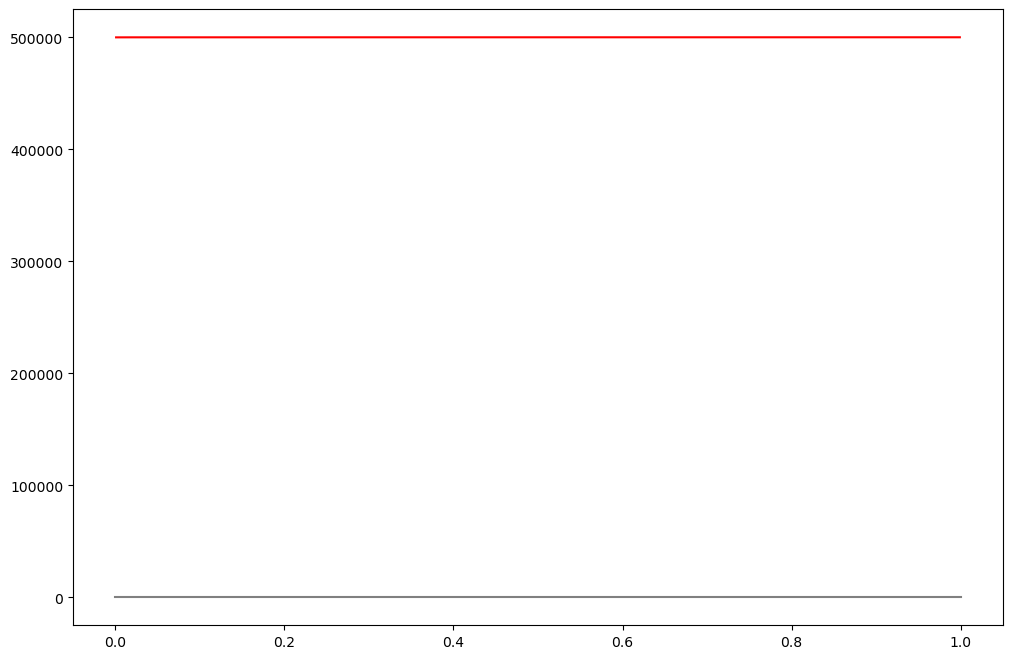

Initial x0 = 0.50000
iter=0   bisection, x=0.250000000000000, err=2.500e-01, bounds=(0.00000,0.50000)
iter=1   bisection, x=0.125000000000000, err=1.250e-01, bounds=(0.00000,0.25000)
iter=2   bisection, x=0.062500000000000, err=6.250e-02, bounds=(0.00000,0.12500)
iter=3   bisection, x=0.031250000000000, err=3.125e-02, bounds=(0.00000,0.06250)
iter=4   bisection, x=0.015625000000000, err=1.562e-02, bounds=(0.00000,0.03125)
iter=5   bisection, x=0.007812500000000, err=7.812e-03, bounds=(0.00000,0.01562)
iter=6   bisection, x=0.003906250000000, err=3.906e-03, bounds=(0.00000,0.00781)
iter=7   bisection, x=0.001953125000000, err=1.953e-03, bounds=(0.00000,0.00391)
iter=8   bisection, x=0.000976562500000, err=9.766e-04, bounds=(0.00000,0.00195)
iter=9   bisection, x=0.000488281250000, err=4.883e-04, bounds=(0.00000,0.00098)
iter=10  bisection, x=0.000244140625000, err=2.441e-04, bounds=(0.00000,0.00049)
iter=11  bisection, x=0.000122070312500, err=1.221e-04, bounds=(0.00000,0.00024)
iter=12

In [48]:
# code up the function
a,b,c = 10,-1,500000
f = lambda x: a*np.log(x)+b*np.log(1-x)+c
g = lambda x: a/x - b/(1-x)
# plot of the function
xd = np.linspace(0,1,1000)
plt.plot(xd,f(xd),c='r')
plt.plot([0,1],[0,0],c='grey')
plt.show()
#solver
def newton_bounded(fun,grad,x0=None,a=0,b=1,tol=1e-6,maxiter=100,callback=None):
    '''Implementation of Newton algorithm with bounds'''
    sa,sb = np.sign(fun(a)), np.sign(fun(b))
    if f(a)*f(b)>0:
        raise ValueError('Function has the same sign at the bounds')
    x0 = (a+b)/2 if x0 == None else x0
    for i in range(maxiter):
        f0 = fun(x0)
        newt = x0 - f0/grad(x0) #Newton step
        if not a <= newt <=b:
            # do bisection step
            a,b = (x0,b) if np.sign(f0) == sa else (a,x0)
            x1 = (a+b)/2
            step='bisection'
        else:
            x1 = newt
            step = 'newton'
        err = abs(x1-x0)
        if callback != None: callback(iter=i,type=step,err=err,x0=x0,x1=x1,a=a,b=b)
        if err<tol: 
            break
        x0 = x1
    else:
        raise RuntimeError('Failed to converge in %d iterations'%maxiter)
    return x1

def printiter(**kwargs):
    i = kwargs['iter']
    x = kwargs['x1']
    err = kwargs['err']
    a = kwargs['a']
    b = kwargs['b']
    t = kwargs['type']
    if i == 0:
        print('Initial x0 = {:1.5f}'.format(kwargs['x0']))
        pass
    print('iter={:<3d} {:9s}, x={:1.15f}, err={:1.3e}, bounds=({:1.5f},{:1.5f})'.format(i,t,x,err,a,b))
#     pass

xs = newton_bounded(f,g, callback=printiter)
print("The found solutions is {:1.15f}".format(xs))

In [ ]:
#















# solution below















#

In [ ]:
def newton_bounds(fun,grad,x0=None,bounds=(0,1),
                  tol=1e-6,maxiter=100,callback=None):
    '''Polyalgorithm that combines bisections and Newton-Raphson
       to solve fun(x)=0 within given lower and upper bounds.
       Callback function is invoked at each iteration if given.
    '''
    a,b = bounds
    sa,sb = np.sign(fun(a)),np.sign(fun(b))  # a and b signs, never change
    if sa*sb > 0:
        raise(ValueError('Function has the same signs at the initial lower and upper limits'))
    x0 = (a+b)/2 if x0==None else x0  # midpoint is default x0
    for i in range(maxiter):
        f0 = fun(x0)
        newt = x0 - f0/grad(x0) # Newton step
        if not a < newt < b:
            a,b = (x0,b) if np.sign(f0)*sa > 0 else (a,x0)  # update limits
            x1 = (a+b)/2  # bisections step
            step_type = 'bisection'
        else:
            x1 = newt
            step_type = 'newton'
        err = np.abs(x0-x1)  # save error for both steps
        if callback:
            callback(iter=i,type=step_type,err=err,x0=x0,x1=x1,bounds=(a,b))
        if err < tol:
            break
        x0 = x1
    else:
        raise(RuntimeError('Failed to converge in %d iterations'%maxiter))
    return x1

In [ ]:
def run(a,b,c,plot=False,**kwargs):
    '''Solves the equation with illustrations'''
    assert a*b<0, 'Must have different signs on a and b by the conditions of the problem'
    f = lambda x: a*np.log(x) + b*np.log(1-x) + c
    g = lambda x: a/x - b/(1-x)
    # plot
    if plot:
        xd = np.linspace(0,1,1000)
        plt.plot(xd,f(xd),c='r')
        plt.plot([0,1],[0,0],c='dimgrey')
        plt.show()
    def printiter (**kwargs):
        printiter.cout += 1
        iter = kwargs['iter']
        type = kwargs['type']
        x = kwargs['x1']
        bounds = kwargs['bounds']
        err = kwargs['err']
        if iter == 0:
            print('x0 = {}'.format(kwargs['x0']))
        print('iter={:<3d} {:<9s}  x={:<23} err={:1.4e}   bounds={:}'.format(iter,type,x,err,bounds))
    printiter.cout = 0
    xs = newton_bounds(f,g,bounds=(0,1),callback=printiter,**kwargs)
    print('Converged in %d iterations, x* = %1.16f' % (printiter.cout,xs))

run(1,-4,0.5,plot=True)
run(2,-1,-10,plot=True)
run(2,-3,1e25)
run(1,-1,-5,x0=.9,tol=1e-15)

#### Further learning resources

- Oscar Veliz video on Newton-bisections hybrid (more general)
  [https://www.youtube.com/watch?v=FD3BPTMGJds&t=335s](https://www.youtube.com/watch?v=FD3BPTMGJds&t=335s)  